In [12]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import defaultdict
from collections.abc import Callable
import tqdm
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss

from utilities import (
    Embedding,
    LayerNorm,
    Dropout,
    Linear,
    DictReLU,
    pbt_init,
    pbt_update,
    Optimizer,
    get_dataloader_random_reshuffle,
    evaluate_model,
    update_model,
    get_array_minibatch,
    get_accuracy,
    AdamW
)

In [13]:
config = {
    "device": "cuda",
    "ensemble_shape": (1,),
    "float_dtype": torch.float32,
    "hyperparameter_raw_init_distributions": {
        "dropout_p": torch.distributions.Uniform(
            torch.tensor(0, device="cuda", dtype=torch.float32),
            torch.tensor(.01, device="cuda", dtype=torch.float32)
        ),
        "epsilon": torch.distributions.Uniform(
            torch.tensor(-10, device="cuda", dtype=torch.float32),
            torch.tensor(-5, device="cuda", dtype=torch.float32)
        ),
        "first_moment_decay": torch.distributions.Uniform(
            torch.tensor(-3, device="cuda", dtype=torch.float32),
            torch.tensor(0, device="cuda", dtype=torch.float32)
        ),
        "learning_rate": torch.distributions.Uniform(
            torch.tensor(-5, device="cuda", dtype=torch.float32),
            torch.tensor(-1, device="cuda", dtype=torch.float32)
        ),
        "second_moment_decay": torch.distributions.Uniform(
            torch.tensor(-5, device="cuda", dtype=torch.float32),
            torch.tensor(-1, device="cuda", dtype=torch.float32)
        ),
        "weight_decay": torch.distributions.Uniform(
            torch.tensor(-5, device="cuda", dtype=torch.float32),
            torch.tensor(-1, device="cuda", dtype=torch.float32)
        )
    },
    "hyperparameter_raw_perturb": {
        "dropout_p": torch.distributions.Normal(
            torch.tensor(0, device="cuda", dtype=torch.float32),
            torch.tensor(.01, device="cuda", dtype=torch.float32)
        ),
        "epsilon": torch.distributions.Normal(
            torch.tensor(0, device="cuda", dtype=torch.float32),
            torch.tensor(1, device="cuda", dtype=torch.float32)
        ),
        "first_moment_decay": torch.distributions.Normal(
            torch.tensor(0, device="cuda", dtype=torch.float32),
            torch.tensor(1, device="cuda", dtype=torch.float32)
        ),
        "learning_rate": torch.distributions.Normal(
            torch.tensor(0, device="cuda", dtype=torch.float32),
            torch.tensor(1, device="cuda", dtype=torch.float32)
        ),
        "second_moment_decay": torch.distributions.Normal(
            torch.tensor(0, device="cuda", dtype=torch.float32),
            torch.tensor(1, device="cuda", dtype=torch.float32)
        ),
        "weight_decay": torch.distributions.Normal(
            torch.tensor(0, device="cuda", dtype=torch.float32),
            torch.tensor(1, device="cuda", dtype=torch.float32)
        ),
    },
    "hyperparameter_transforms": {
        "dropout_p": lambda p: p.clip(0,1),
        "epsilon": lambda log10: 10 ** log10,
        "first_moment_decay": lambda x: (1 - 10 ** x).clamp(0, 1),
        "learning_rate": lambda log10: 10 ** log10,
        "second_moment_decay": lambda x: (1 - 10 ** x).clamp(0, 1),
        "weight_decay": lambda log10: 10 ** log10,
    },
    "improvement_threshold": 1e-4,
    "minibatch_size": 128,
    "pbt": True,
    "seed": 1,
    "sequence_size": 64,
    "steps_num": 10000,
    "steps_without_improvement": 5_000,
    "valid_interval": 500,
    "welch_confidence_level": .95,
    "welch_sample_size": 1024,
    "embedding_dim": 60,
    "dropout_p": torch.tensor([.1], device='cuda'),
    "n_heads": 3,
    "block_num": 1,
    "minibatch_size_eval": 512
}

In [14]:
torch.manual_seed(config["seed"])

In [15]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d, device=config["device"])
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

pos_embed = get_positional_embeddings(64, config["embedding_dim"])[None, :]

In [16]:
class EmbeddingBlock(nn.Module):
    def __init__(
        self,
        config,
        embedding_dim
    ):
        super().__init__()
        
        self.piece_embed = Embedding(config, embedding_dim, vocabulary_size=7)
        self.player_embed = Embedding(config, embedding_dim, vocabulary_size=2)
        self.dropout = Dropout(config)
        self.pos_embed = pos_embed
        
    def forward(self, input):
        input = input[0]
        embedded_pieces = self.dropout({'features': self.piece_embed(input[...,0])})
        embedded_players = self.dropout({'features': self.player_embed(input[...,1])})
        embedded_pos = self.pos_embed
        
        output = embedded_pieces['features'] + embedded_players['features'] + embedded_pos
        
        return {'features': output.to(config["device"]), 'mask': torch.ones((config['minibatch_size'], config['sequence_size']), device=config['device']).to(torch.bool)}
        

In [17]:
class MultiHeadSelfAttentionBlock(nn.Module):
    """
    Pre-LN multi-head self-attention block.

    Parameters
    ----------
    attention_head_num : `int`
        The number of attention heads.
    config : `int`
        Configuration dictionary. Required key-value pairs:
        `"device"` : `str`
            The device to store parameters on.
        `"dropout_p"` : `torch.Tensor`
            Dropout probability tensor, of shape `ensemble_shape`.
        `"ensemble_shape"` : `tuple[int]`
            Ensemble shape.      
        `"float_dtype"` : `torch.dtype`
            The floating point datatype to use for the parameters.
    embedding_dim : `int`
        The feature dimension of internal representations.

    Calling
    -------
    Instance calls require one positional argument:
    batch : `dict`
        The input data dictionary. Required keys:
        `"features"` : `torch.Tensor`
            Tensor of element-level features, of shape
            `batch_shape + (sequence_dim, embedding_dim)` or
            `ensemble_shape + batch_shape + (sequence_dim, embedding_dim)`
        `"mask"` : `torch.Tensor`
            Mask showing which entries are not padding, of shape
            `batch_shape + (sequence_dim,)` or
            `ensemble_shape + batch_shape + (sequence_dim,)`
    """
    def __init__(
        self,
        attention_head_num: int,
        config: dict,
        embedding_dim: int
    ):
        super().__init__()

        self.attention_head_num = attention_head_num
        self.config = config
        self.dropout = Dropout(config)
        self.layer_norm = LayerNorm(
            config,
            embedding_dim
        )

        (
            self.key_weights,
            self.output_weights,
            self.query_weights,
            self.value_weights
        ) = (
            Linear(
                config,
                embedding_dim,
                embedding_dim,
                bias=False
            )
            for _ in range(4)
        )


    def forward(
        self,
        batch: dict
    ) -> dict:
        skip = batch["features"]
        batch = self.layer_norm(batch)
        residual, mask = (batch[key] for key in ("features", "mask"))

        sequence_dim, embedding_dim = residual.shape[-2:]
        key_dim = embedding_dim // self.attention_head_num

        key, query, value = (
            (
                linear(residual)
            ).reshape(
                residual.shape[:-1] + (self.attention_head_num, key_dim)
            ).transpose(-3, -2)
            for linear in (
                self.key_weights,
                self.query_weights,
                self.value_weights
            )
        )
        
        
        arange = torch.arange(sequence_dim, device=mask.device)
        attention_mask = mask[..., None, :] & mask[..., None]
        attention_mask |= (arange == arange[:, None])

        pooled_values = F.scaled_dot_product_attention(
            query,
            key,
            value,
            attention_mask[..., None, :, :]
        )

        residual = pooled_values.transpose(-3, -2).reshape(residual.shape)
        residual = self.output_weights(residual)
        residual = self.dropout({"features": residual})["features"]

        features = skip + residual

        return batch | {"features": features}

In [18]:
class FeedForwardBlock(torch.nn.Module):
    """
    Pre-LN feedforward block.

    Parameters
    ----------
    config : `int`
        Configuration dictionary. Required key-value pairs:
        `"device"` : `str`
            The device to store parameters on.
        `"dropout_p"` : `torch.Tensor`
            Dropout probability tensor, of shape `ensemble_shape`.
        `"ensemble_shape"` : `tuple[int]`
            Ensemble shape.      
        `"float_dtype"` : `torch.dtype`
            The floating point datatype to use for the parameters.
    embedding_dim : `int`
        The feature dimension of internal representations.

    Calling
    -------
    Instance calls require one positional argument:
    batch : `dict`
        The input data dictionary. Required key:
        `"features"` : `torch.Tensor`
            Tensor of element-level features, of shape
            `batch_shape + (sequence_dim, embedding_dim)` or
            `ensemble_shape + batch_shape + (sequence_dim, embedding_dim)`
    """
    def __init__(
        self,
        config: dict,
        embedding_dim: int
    ):
        super().__init__()

        self.residual_f = torch.nn.Sequential(
            LayerNorm(
                config,
                embedding_dim
            ),
            Linear(
                config,
                embedding_dim,
                embedding_dim,
                init_multiplier=2 ** .5
            ),
            DictReLU(),
            Linear(
                config,
                embedding_dim,
                embedding_dim
            ),
            Dropout(config)
        )


    def forward(self, batch: dict) -> dict:
        skip = batch

        residual = self.residual_f(batch)

        features = skip["features"] + residual["features"]

        return batch | {"features": features}

In [19]:
def train_supervised(
    config: dict,
    dataset_train: dict,
    dataset_valid: dict,
    get_loss: Callable[[dict, torch.Tensor], torch.Tensor],
    get_metric: Callable[[dict, torch.Tensor], torch.Tensor],
    model: torch.nn.Module,
    optimizer: Optimizer,
    target_key="target"
) -> dict:
    """
    Population-based training on a supervised learning task.
    Tuned hyperparameters are given by raw values and transformations.
    This way, the hyperparameters are perturbed by
    additive noise on raw values.

    Parameters
    ----------
    config : `dict`
        Configuration dictionary. Required key-value pairs:
        `"ensemble_shape"` : tuple[int]
            Ensemble shape. We assume this is a 1-dimensional tuple
            with dimensions the population size.
        `"hyperparameter_raw_init_distributions"` : `dict`
            Dictionary that maps tuned hyperparameter names
            to `torch.distributions.Distribution` of raw hyperparameter values.
            Required keys:
            `"learning_rate"`:
                The learning rate of stochastic gradient descent.
        `"hyperparameter_raw_perturbs"` : `dict`
            Dictionary that maps tuned hyperparameter names
            to `torch.distributions.Distribution` of additive noise.
        `"hyperparameter_transforms"` : `dict`
            Dictionary that maps tuned hyperparameter names
            to transformations of raw hyperparameter values.
        `"improvement_threshold"` : `float`
            A new metric score has to be this much better
            than the previous best to count as an improvement.
        `"minibatch_size"` : `int`
            Minibatch size to use in a training step.
        `"minibatch_size_eval"` : `int`
            Minibatch size to use in evaluation.
            On CPU, should be about the same as `minibatch_size`.
            On GPU, should be as big as possible without
            incurring an Out of Memory error.
        `"pbt"` : `bool`
            Whether to use PBT updates in validations.
            If `False`, the algorithm just samples hyperparameters at start,
            then keeps them constant.
        `"steps_num"` : `int`
            Maximum number of training steps.
        `"steps_without_improvement`" : `int`
            If the number of training steps without improvement
            exceeds this value, then training is stopped.
        `"valid_interval"` : `int`
            Frequency of evaluations, measured in number of training steps.
        `"welch_confidence_level"` : `float`
            The confidence level in Welch's t-test
            that is used in determining if a population member
            is to be replaced by another member with perturbed hyperparameters.
        `"welch_sample_size"` : `int`
            The last this many validation metrics are used
            in Welch's t-test.
    dataset_train : `dict`
        The dataset to train the model on.
    dataset_valid : `dict`
        The dataset to evaluate the model on.
    `get_loss` : `Callable[[dict, torch.Tensor], torch.Tensor]`
        A function that maps a pair of model output and target value tensor
        to a tensor of losses per ensemble member.
    `get_metric` : `Callable[[dict, torch.Tensor], torch.Tensor]`
        A function that maps a pair of model output and target value tensor
        to a tensor of metrics per ensemble member.
        We assume a greater metric is better.
    `model` : `torch.nn.Module`
        The model ensemble to tune.
    `optimizer` : `Optimizer`
        An optimizer that tracks the parameters of `model`.
    indptr_key : `str`, optional
        If the dataset has sequential entries,
        then this is the key of the index pointer tensor.
        Default: `"indptr"`.
    target_key : `str`, optional
        The key mapped to the target value tensor in the dataset.
        Default: `"target"`
        
    Returns
    -------
    An output dictionary with the following key-value pairs:
        `"source mask"` : `torch.Tensor`
            The source masks of population members
            that were replace by other members in a PBT update
        `"target indices"` : `torch.Tensor`
            The indices of population members
            that the member where the source mask is to were replaced with.
        `"validation metric"` : `torch.Tensor`
            The validation metrics at evaluation steps.

        In addition, for each tuned hyperparameter name,
        we include a `torch.Tensor` of values per update.
    """
    ensemble_shape = config["ensemble_shape"]
    if len(ensemble_shape) != 1:
        raise ValueError(f"The number of dimensions in the ensemble shape should be 1 for the  population size, but it is {len(ensemble_shape)}")

    config_local = dict(config)
    log = defaultdict(list)

    pbt_init(config_local, log)

    update_model(config_local, model)
    optimizer.update_config(config_local)

    best_valid_metric = -torch.inf
    progress_bar = tqdm.trange(config["steps_num"])
    steps_without_improvement = 0
    train_dataloader = get_dataloader_random_reshuffle(
        config,
        dataset_train["features"],
        dataset_train["labels"]
    )

    for step_id in progress_bar:
        model.train()
        minibatch = next(train_dataloader)
        optimizer.zero_grad()
        
        predict = model(minibatch[0])[0][...,0]
        target = minibatch[1][0]

        loss = get_loss(predict, target).sum()
        
        loss.backward()
        optimizer.step()
        
        if step_id % config["valid_interval"] == 0:
            model.eval()
            with torch.no_grad():
                split_name = "validation"
                minibatch = next(train_dataloader)
                optimizer.zero_grad()

                predict = model(minibatch[0])[0][...,0]
                target = minibatch[1][0]
                
                
                metric = (predict.argmax(dim=-1) == target).to(config["float_dtype"]).mean()
                
                # log[f"{split_name} loss"].append(loss)
                log[f"{split_name} metric"].append(metric)
                # print(
                #     f"{split_name} loss {loss.min().cpu().item():.4f}"
                # )
                print(
                    f"{split_name} metric {metric.max().cpu().item():.4f}"
                )

                best_last_metric = log["validation metric"][-1].max()
                print(
                    f"Best last metric {best_last_metric.cpu().item():.2f}",
                    flush=True
                )
                if (
                    best_valid_metric + config["improvement_threshold"]
                ) < best_last_metric:
                    print(
                        f"New best metric",
                        flush=True
                    )
                    best_valid_metric = best_last_metric
                    steps_without_improvement = 0
                else:
                    print(
                        f"Best metric {best_valid_metric.cpu().item():.2f}",
                        flush=True
                    )
                    steps_without_improvement += config["valid_interval"]
                    if steps_without_improvement > config[
                        "steps_without_improvement"
                    ]:
                        break

                if config["pbt"] and (len(log["validation metric"]) >= config[
                    "welch_sample_size"
                ]):
                    evaluations = torch.stack(
                        log["validation metric"][-config["welch_sample_size"]:]
                    )
                    pbt_update(
                        config_local, evaluations, log, optimizer.get_parameters()
                    )

                    update_model(config_local, model)
                    optimizer.update_config(config_local)


    progress_bar.close()
    for key, value in log.items():
        if isinstance(value, list):
            log[key] = torch.stack(value)

    return log

In [20]:
class Transformer(nn.Module):
    def __init__(self, config):
        super(Transformer, self).__init__()
        
        embedding_dim = config["embedding_dim"]
        n_heads = config["n_heads"]
        block_num = config["block_num"]
        
        # create embedding block
        self.EmbeddingBlock = EmbeddingBlock(config, embedding_dim)
        
        # make repeated transformer block
        blocks = []
        for _ in range(block_num):
            blocks.extend([
                MultiHeadSelfAttentionBlock(n_heads, config, embedding_dim),
                FeedForwardBlock(config, embedding_dim)
            ])
        self.MHA_FF_Block = nn.Sequential(*blocks)
        
        # use Linear to create logits
        self.Linear = Linear(config, embedding_dim, 1)
        
        # use softmax
        self.softmax = nn.Softmax()
        

    def forward(self, input):
        embedded_inputs = self.EmbeddingBlock(input)
        
        out = self.MHA_FF_Block(embedded_inputs)
        
        logits = self.Linear(out)["features"]
        
        logits = self.softmax(logits)
        
        return logits

In [21]:
dataset = torch.load('data/dataset_v2.pt', map_location=config["device"])
dataset_train, dataset_valid = {}, {}
dataset_train["features"], dataset_valid["features"], dataset_train["labels"], dataset_valid["labels"] = train_test_split(
    dataset["features"], dataset["labels"][:,0], test_size=0.2, random_state=config['seed'])


C:\Users\Anu\AppData\Local\Temp\ipykernel_8800\1019586205.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load('data/dataset_v2.pt', map_location=config[

In [22]:
model = Transformer(config).to(config["device"])
optimizer = AdamW(model.parameters())

log = train_supervised(
    config,
    dataset_train,
    dataset_valid,
    CrossEntropyLoss(),
    get_accuracy,
    model,
    optimizer,
    target_key="labels"
)

  0%|          | 0/10000 [00:00<?, ?it/s]

validation metric 0.0000
Best last metric 0.00
New best metric


c:\ProgramData\Anaconda3\envs\deep_learning\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  5%|▍         | 495/10000 [00:07<02:21, 66.96it/s]

validation metric 0.2031
Best last metric 0.20
New best metric


 10%|▉         | 999/10000 [00:15<02:13, 67.43it/s]

validation metric 0.1953
Best last metric 0.20
Best metric 0.20


 15%|█▍        | 1496/10000 [00:22<02:04, 68.16it/s]

validation metric 0.1719
Best last metric 0.17
Best metric 0.20


 20%|██        | 2000/10000 [00:29<01:59, 66.75it/s]

validation metric 0.2266
Best last metric 0.23
New best metric


 25%|██▍       | 2497/10000 [00:37<01:49, 68.24it/s]

validation metric 0.2188
Best last metric 0.22
Best metric 0.23


 30%|██▉       | 2994/10000 [00:44<01:41, 68.74it/s]

validation metric 0.1797
Best last metric 0.18
Best metric 0.23


 35%|███▍      | 3498/10000 [00:52<01:34, 68.56it/s]

validation metric 0.2500
Best last metric 0.25
New best metric


 40%|███▉      | 3995/10000 [00:59<01:27, 68.35it/s]

validation metric 0.2188
Best last metric 0.22
Best metric 0.25


 45%|████▍     | 4499/10000 [01:06<01:21, 67.80it/s]

validation metric 0.2188
Best last metric 0.22
Best metric 0.25


 50%|████▉     | 4996/10000 [01:14<01:14, 67.25it/s]

validation metric 0.1484
Best last metric 0.15
Best metric 0.25


 55%|█████▌    | 5500/10000 [01:21<01:05, 68.29it/s]

validation metric 0.2031
Best last metric 0.20
Best metric 0.25


 60%|█████▉    | 5997/10000 [01:28<00:58, 68.41it/s]

validation metric 0.2344
Best last metric 0.23
Best metric 0.25


 65%|██████▍   | 6494/10000 [01:36<00:51, 68.00it/s]

validation metric 0.2266
Best last metric 0.23
Best metric 0.25


 70%|██████▉   | 6998/10000 [01:43<00:43, 68.40it/s]

validation metric 0.2109
Best last metric 0.21
Best metric 0.25


 75%|███████▍  | 7495/10000 [01:50<00:36, 68.50it/s]

validation metric 0.2109
Best last metric 0.21
Best metric 0.25


 80%|███████▉  | 7999/10000 [01:58<00:29, 66.98it/s]

validation metric 0.1797
Best last metric 0.18
Best metric 0.25


 85%|████████▍ | 8496/10000 [02:05<00:22, 68.18it/s]

validation metric 0.2422
Best last metric 0.24
Best metric 0.25


 90%|█████████ | 9000/10000 [02:12<00:14, 68.32it/s]

validation metric 0.1953
Best last metric 0.20
Best metric 0.25


 90%|█████████ | 9000/10000 [02:12<00:14, 67.69it/s]


In [23]:
log

defaultdict(list,
            {'dropout_p': tensor([[0.0022]], device='cuda:0'),
             'epsilon': tensor([[2.4228e-09]], device='cuda:0'),
             'first_moment_decay': tensor([[0.9281]], device='cuda:0'),
             'learning_rate': tensor([[0.0005]], device='cuda:0'),
             'second_moment_decay': tensor([[0.9996]], device='cuda:0'),
             'weight_decay': tensor([[0.0112]], device='cuda:0'),
             'validation metric': tensor([0.0000, 0.2031, 0.1953, 0.1719, 0.2266, 0.2188, 0.1797, 0.2500, 0.2188,
                     0.2188, 0.1484, 0.2031, 0.2344, 0.2266, 0.2109, 0.2109, 0.1797, 0.2422,
                     0.1953], device='cuda:0')})

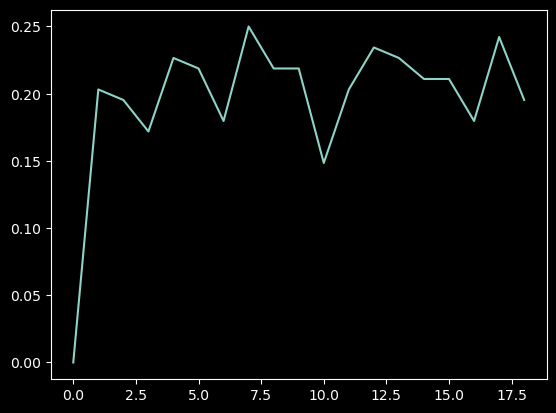

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.lineplot(log["validation metric"].cpu())
plt.show()